# Train and Save Models

Run this script to train all the models on the training data (DynaSent round 2) and save the models as .pt files.

## Set-up

See [the first notebook in this unit](sst_01_overview.ipynb#Set-up) for set-up instructions.

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
from datasets import load_dataset
import transformers

import sst
import utils

In [2]:
transformers.utils.logging.set_verbosity_error()
device = "cuda" if torch.cuda.is_available() else "cpu"
utils.fix_random_seeds()

## Dataset

Our primary train/dev/test set is DynaSent Round 2. See more details here: https://huggingface.co/datasets/dynabench/dynasent

In [3]:
dyna_r1 = load_dataset("dynabench/dynasent", "dynabench.dynasent.r1.all")
dyna_r1_train = dyna_r1['train'].to_pandas()
dyna_r1_dev = dyna_r1['validation'].to_pandas()
dyna_r2 = load_dataset("dynabench/dynasent", "dynabench.dynasent.r2.all")
dyna_r2_train = dyna_r2['train'].to_pandas()
dyna_r2_dev = dyna_r2['validation'].to_pandas()
print(f'dyna_r2_train.shape: {dyna_r2_train.shape}')
print(f'dyna_r2_dev.shape: {dyna_r2_dev.shape}')

TRAIN_DATAFRAMES = [dyna_r1_train, dyna_r2_train]
TRAIN_DATAFRAMES = [dyna_r2_train] # Only train on r2 for speed
DEV_DATAFRAMES = [dyna_r1_dev, dyna_r2_dev]

print(f'Train dataset length: {sum([len(df) for df in TRAIN_DATAFRAMES])}')
print(f'Test dataset length:  {sum([len(df) for df in DEV_DATAFRAMES])}')

Reusing dataset dynabench_dyna_sent (C:\Users\Gabe\.cache\huggingface\datasets\dynabench___dynabench_dyna_sent\dynabench.dynasent.r1.all\1.1.0\ab89971d9ae1aacc59ed44d6855bf0e89167417257e2c2666f38e532148f2967)
100%|██████████| 3/3 [00:00<00:00, 374.64it/s]
Reusing dataset dynabench_dyna_sent (C:\Users\Gabe\.cache\huggingface\datasets\dynabench___dynabench_dyna_sent\dynabench.dynasent.r2.all\1.1.0\ab89971d9ae1aacc59ed44d6855bf0e89167417257e2c2666f38e532148f2967)
100%|██████████| 3/3 [00:00<00:00, 428.16it/s]

dyna_r2_train.shape: (13065, 12)
dyna_r2_dev.shape: (720, 12)
Train dataset length: 13065
Test dataset length:  4320


In [4]:
dyna_r2_train.sample(1, random_state=1).to_dict(orient='records')

[{'id': 'r2-0002527',
  'hit_ids': array(['y23152'], dtype=object),
  'sentence': "The car is unsafe and Peoria Ford just says  us it's Ford.",
  'sentence_author': 'w1985',
  'has_prompt': True,
  'prompt_data': {'indices_into_review_text': array([378, 442]),
   'review_rating': 1,
   'prompt_sentence': "The car is unsafe and Peoria Ford just says it not us it's Ford.",
   'review_id': 'kUMkF_C6KVS4bRbOx_libQ'},
  'model_1_label': 'negative',
  'model_1_probs': {'negative': 0.7570458054542542,
   'positive': 0.14265362918376923,
   'neutral': 0.1003006249666214},
  'text_id': 'r2-0002527',
  'label_distribution': {'positive': array(['w121'], dtype=object),
   'negative': array(['w128', 'w23', 'w130', 'w80'], dtype=object),
   'neutral': array([], dtype=object),
   'mixed': array([], dtype=object)},
  'gold_label': 'negative',
  'metadata': {'split': 'train',
   'round': 2,
   'subset': 'all',
   'model_in_the_loop': 'RoBERTa'}}]

Here is the label distribution:

In [5]:
print("dyna_r1_train:")
print(dyna_r1_train.gold_label.value_counts())
print("dyna_r2_train:")
print(dyna_r2_train.gold_label.value_counts())
print("dyna_r1_dev:")
print(dyna_r1_dev.gold_label.value_counts())
print("dyna_r2_dev:")
print(dyna_r2_dev.gold_label.value_counts())


dyna_r1_train:
neutral     45076
positive    21391
negative    14021
Name: gold_label, dtype: int64
dyna_r2_train:
positive    6038
negative    4579
neutral     2448
Name: gold_label, dtype: int64
dyna_r1_dev:
positive    1200
neutral     1200
negative    1200
Name: gold_label, dtype: int64
dyna_r2_dev:
neutral     240
negative    240
positive    240
Name: gold_label, dtype: int64


<AxesSubplot:>

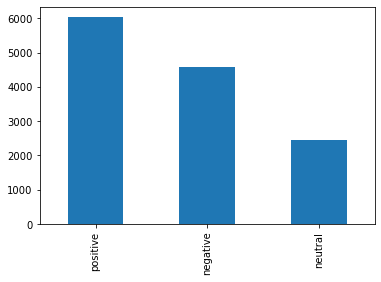

In [6]:
dyna_r2_train.gold_label.value_counts().plot.bar()

<AxesSubplot:>

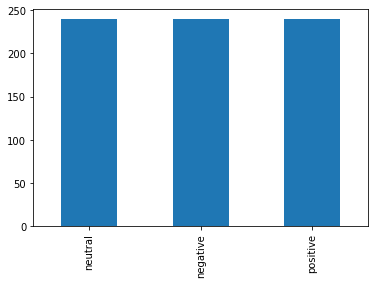

In [7]:
dyna_r2_dev.gold_label.value_counts().plot.bar()

## RNNClassifier wrapper

This section illustrates how to use `sst.experiment` with `TorchRNNClassifier`.

To featurize examples for an RNN, we can just get the words in order, letting the model take care of mapping them into an embedding space.

In [8]:
def rnn_phi(text):
    return text.split()

The model wrapper gets the vocabulary using `sst.get_vocab`. If you want to use pretrained word representations in here, then you can have `fit_rnn_classifier` build that space too; see [this notebook section for details](sst_03_neural_networks.ipynb#Pretrained-embeddings). See also [torch_model_base.py](torch_model_base.py) for details on the many optimization parameters that `TorchRNNClassifier` accepts.

In [9]:
# def fit_rnn_classifier(X, y):
#     sst_glove_vocab = utils.get_vocab(X, mincount=2)
#     mod = TorchRNNClassifier(
#         sst_glove_vocab,
#         early_stopping=True)
#     mod.fit(X, y)
#     return mod

In [10]:
# rnn_experiment = sst.experiment(
#     dyna_r2_train,
#     rnn_phi,
#     fit_rnn_classifier,
#     vectorize=False,
#     assess_dataframes=DEV_DATAFRAMES)


### Train and Save the Models

In [11]:
from sentiment_models import build_untrained_classifier_models

print('Building models...', ' ' * 1000, end='\r')
(sentiment_classifier_lstm_base,
    sentiment_classifier_roberta_base,
    sentiment_classifier_dynasent_base,
    sentiment_classifier_lstm_aan,
    sentiment_classifier_roberta_aan,
    sentiment_classifier_dynasent_aan) = build_untrained_classifier_models(TRAIN_DATAFRAMES)

def phi(text):
    return text

def train_classifier(X, y):
    bestmod = sentiment_classifier_dynasent_base
    bestmod.fit(X, y)
    return bestmod

print('Beginning experiment...', ' ' * 1000, end='\r')
experiment = sst.experiment(
    TRAIN_DATAFRAMES,
    phi,
    train_classifier,
    assess_dataframes=DEV_DATAFRAMES,
    vectorize=False,
    verbose=True,
    random_state=42)

torch.save(experiment['model'], os.path.join('models', 'sentiment_classifier_dynasent_base.pt'))

# del transformer_classifier_xval # Free memory, for continually test without restarting the kernel

Assessment dataset 1
              precision    recall  f1-score   support

    negative      0.771     0.782     0.777      1200
     neutral      0.703     0.877     0.780      1200
    positive      0.871     0.642     0.740      1200

    accuracy                          0.767      3600
   macro avg      0.782     0.767     0.765      3600
weighted avg      0.782     0.767     0.765      3600

Assessment dataset 2
              precision    recall  f1-score   support

    negative      0.593     0.742     0.659       240
     neutral      0.686     0.583     0.631       240
    positive      0.759     0.683     0.719       240

    accuracy                          0.669       720
   macro avg      0.680     0.669     0.670       720
weighted avg      0.680     0.669     0.670       720

Mean of macro-F1 scores: 0.718


{'model': SentimentClassifierRoberta(
 	batch_size=16,
 	max_iter=10,
 	eta=2e-05,
 	optimizer_class=<class 'torch.optim.adam.Adam'>,
 	l2_strength=0,
 	gradient_accumulation_steps=2,
 	max_grad_norm=None,
 	validation_fraction=0.1,
 	early_stopping=True,
 	n_iter_no_change=5,
 	warm_start=False,
 	tol=1e-05,
 	hidden_dim=50,
 	hidden_activation=Tanh()),
 'phi': <function __main__.phi(text)>,
 'train_dataset': {'X': ["We enjoyed our first and last meal in Toronto at Bombay Palace, and I can't think of a better way to book our journey.",
   "I tried a new place. I can't wait to return and try more.",
   'The buffalo chicken was not good, but very costly.',
   'The hotel offered complimentary breakfast.',
   'It work very well',
   'I was so tired, but was comforted by the smoking hazy smell ',
   'The BMW was costly.',
   'I came for brunch with a bad group of girlfriends.',
   'And we all did...one by one and went to bar bar that has a welcoming atmosphere with polite & pleasant staff!

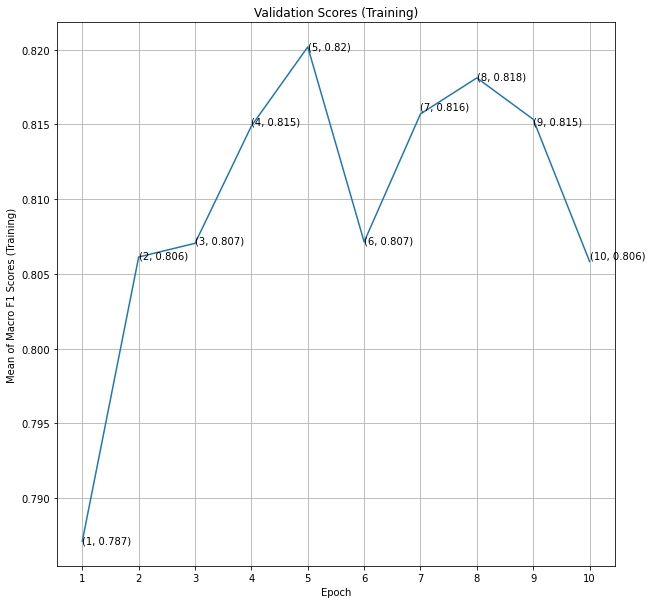

In [22]:
# Plot validation scores computed during training on held-out portions of the train set
def plot_scores():
    from matplotlib import pyplot as plt
    # TODO graph .validation_scores
    plt.rcParams["figure.figsize"] = 10, 10
    scores = experiment['model'].validation_scores
    epochs = list(range(1, len(scores) + 1))
    plt.plot(epochs, scores)
    plt.ylabel('Mean of Macro F1 Scores (Training)')
    plt.xlabel('Epoch')
    plt.title('Validation Scores (Training)')
    plt.grid()
    plt.xticks(epochs)

    # Data labels
    rounded_scores = [round(score, 3) for score in scores]
    for xy in zip(epochs, rounded_scores):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plot_scores()
experiment


a = torch.load(os.path.join('models', 'exp_sentiment_classifier_dynasent_base.pt'))
a

## Bakeoff [1 point]

As we said above, the bakeoff evaluation data is the official SST test-set release and a new test set derived from the same sources and labeling methods as for `bakeoff_dev`.

For this bakeoff, you'll evaluate your original system from the above homework problem on these test sets. Our metric will be the mean of the macro-F1 values, which weights both datasets equally despite their differing sizes.

The central requirement for your system is that you have define a `predict_one` method for it that maps a text (str) directly to a label prediction – one of 'positive', 'negative', 'neutral'. If you used `sst.experiment` with `vectorize=True`, then the following function (for `softmax_experiment`) will be easy to adapt – you probably just need to change the variable `softmax_experiment` to the variable for your experiment output.

In [13]:
def predict_one_softmax(text):
    # Singleton list of feature dicts:
    feats = [softmax_experiment['phi'](text)]
    # Vectorize to get a feature matrix:
    X = softmax_experiment['train_dataset']['vectorizer'].transform(feats)
    # Standard sklearn `predict` step:
    preds = softmax_experiment['model'].predict(X)
    # Be sure to return the only member of the predictions,
    # rather than the singleton list:
    return preds[0]

If you used an RNN like the one we demoed above, then featurization is a bit more straightforward:

In [14]:
def predict_one_rnn(text):
    # List of tokenized examples:
    X = [rnn_experiment['phi'](text)]
    # Standard `predict` step on a list of lists of str:
    # TODO be sure to change the model to eval mode before predicting
    preds = rnn_experiment['model'].predict(X)
    # Be sure to return the only member of the predictions,
    # rather than the singleton list:
    return preds[0]

The following function is used to create the bakeoff submission file. Its arguments are your `predict_one` function and an output filename (str).

In [15]:
def create_bakeoff_submission(
        predict_one_func,
        output_filename='cs224u-sentiment-bakeoff-entry.csv'):
    import pandas as pd

    bakeoff_test = sst.bakeoff_test_reader(SST_HOME)
    sst_test = sst.test_reader(SST_HOME)
    bakeoff_test['dataset'] = 'bakeoff'
    sst_test['dataset'] = 'sst3'
    df = pd.concat((bakeoff_test, sst_test))

    df['prediction'] = df['sentence'].apply(predict_one_func)

    df.to_csv(output_filename, index=None)

~~Thus, for example, the following will create a bake-off entry based on `predict_one_softmax`:~~

Create a bake-off entry based on our custom model:

In [16]:
# Create bakeoff submission, takes 2-3 minutes on a GPU.
if 'IS_GRADESCOPE_ENV' not in os.environ:
    def predict_one_original(text):
        # List of tokenized examples:
        X = [transformer_classifier_xval['phi'](text)]
        # Change to eval mode for prediction, though this seems to have no effect
        transformer_classifier_xval['model'].model.eval()
        # Standard `predict` step on a list of lists of str:
        preds = transformer_classifier_xval['model'].predict(X)
        # Be sure to return the only member of the predictions,
        # rather than the singleton list:
        return preds[0]

    create_bakeoff_submission(predict_one_original)

NameError: name 'SST_HOME' is not defined

This creates a file `cs224u-sentiment-bakeoff-entry.csv` in the current directory. That file should be uploaded as-is. Please do not change its name.

Only one upload per team is permitted, and you should do no tuning of your system based on what you see in our bakeoff prediction file – you should not study that file in anyway, beyond perhaps checking that it contains what you expected it to contain. The upload function will do some additional checking to ensure that your file is well-formed.

People who enter will receive the additional homework point, and people whose systems achieve the top score will receive an additional 0.5 points. We will test the top-performing systems ourselves, and only systems for which we can reproduce the reported results will win the extra 0.5 points.

Late entries will be accepted, but they cannot earn the extra 0.5 points.

## Submission Instruction

Review and follow the [Homework and bake-off code: Formatting guide](hw_formatting_guide.ipynb).
Please do not change the file name as described below.

Submit the following files to Gradescope:

- `hw_sentiment.ipynb` (this notebook)
- `cs224u-sentiment-bakeoff-entry.csv` (bake-off output)
